<center><img src="http://identity.stanford.edu/overview/images/emblems/SU_BlockStree_2color.png" width="200" style="display: inline-block"><img src="http://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/Main_fermi_logo_HI.jpg/682px-Main_fermi_logo_HI.jpg" width="200" style="display: inline-block"><img src="http://www.astro.wisc.edu/~russell/HAWCLogo.png" width="200" style="display: inline-block"></center>
<h1> Basic PHA FITS Analysis with 3ML</h1>
<br/>
Giacomo Vianello (Stanford University)
<a href="mailto:giacomov@stanford.edu">giacomov@stanford.edu</a>

<h2>IPython Notebook setup. </h2>
This is needed only if you are using the <a href=http://ipython.org/notebook.html>IPython Notebook</a> on your own computer, it is NOT needed if you are on threeml.stanford.edu.
This line will activate the support for inline display of matplotlib images:

In [1]:
from threeML import *

from threeML.io.package_data import get_path_of_data_dir

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

%matplotlib notebook
%load_ext snakeviz

Configuration read from /Users/jburgess/.threeML/threeML_config.yml


INFO:keyring.backend:Loading KWallet
INFO:keyring.backend:Loading SecretService
INFO:keyring.backend:Loading Windows
INFO:keyring.backend:Loading chainer
INFO:keyring.backend:Loading macOS


## Simple standard analysis

Here we can see a simple example of basic spectral analysis for FITS PHA files from the Fermi Gamma-ray Burst Monitor. FITS PHA files are read in with the **OGIPLike** plugin that supports reading TYPE I & II PHA files with properly formatted <a  href=https://heasarc.gsfc.nasa.gov/docs/heasarc/ofwg/docs/spectra/ogip_92_007/node5.html>OGIP</a> keywords.  

Here, we examine a TYPE II PHA file. Since there are multiple spectra embedded in the file, we must either use the XSPEC style **{spectrum_number}** syntax to access the appropriate spectum or use the keyword spectrum_number=1.

In [2]:
triggerName = 'bn090217206'
ra = 204.9
dec = -8.4

#Data are in the current directory

datadir = os.path.join(get_path_of_data_dir(),'datasets','bn090217206')

#Create an instance of the GBM plugin for each detector
#Data files
obsSpectrum = os.path.join( datadir, "bn090217206_n6_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n6_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n6_weightedrsp.rsp{1}" )

#Plugin instance
NaI6 = OGIPLike( "NaI6", observation=obsSpectrum, background=bakSpectrum, response=rspFile )

#Choose energies to use (in this case, I exclude the energy
#range from 30 to 40 keV to avoid the k-edge, as well as anything above
#950 keV, where the calibration is uncertain)
NaI6.set_active_measurements( "10.0-30.0", "40.0-950.0" )


Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 4-20
Range 40.0-950.0 translates to channels 26-125
Now using 117 channels out of 128


In [4]:
NaI6.observed_counts

array([ 23, 100, 123, 209, 278, 245, 359, 485, 573, 616, 608, 667, 690,
       610, 716, 704, 736, 693, 682, 602, 739, 711, 659, 588, 445, 413,
       410, 363, 299, 339, 336, 304, 358, 349, 324, 345, 334, 319, 365,
       346, 412, 359, 321, 354, 274, 360, 342, 264, 283, 299, 296, 291,
       270, 268, 259, 250, 268, 220, 264, 249, 220, 238, 225, 220, 197,
       209, 179, 203, 186, 201, 188, 184, 145, 143, 141, 118, 113, 111,
       105, 113, 104, 118, 100, 115,  96,  76,  71,  65,  64,  62,  66,
        44,  50,  69,  50,  43,  40,  53,  35,  50,  55,  40,  54,  49,
        40,  39,  39,  35,  37,  37,  24,  27,  29,  22,  37,  23,  29,
        21,  33,  28,  16,  17,  12,  13,  21,  12, 371, 905])

As we can see, the plugin probes the data to choose the appropriate likelihood for the given obseration and background data distribution. 

In GBM, the background is estimated from a polynomial fit and hence has Gaussian distributed errors via error propagation.

We can also select the energies that we would like to use in a spectral fit. To understand how energy selections work, there is a detailed docstring:


In [5]:
NaI6.set_active_measurements?

Signature: NaI6.set_active_measurements(*args, **kwargs)
Docstring:
Set the measurements to be used during the analysis. Use as many ranges as you need, and you can specify
either energies or channels to be used.

NOTE to Xspec users: while XSpec uses integers and floats to distinguish between energies and channels
specifications, 3ML does not, as it would be error-prone when writing scripts. Read the following documentation
to know how to achieve the same functionality.

* Energy selections:

They are specified as 'emin-emax'. Energies are in keV. Example:

set_active_measurements('10-12.5','56.0-100.0')

which will set the energy range 10-12.5 keV and 56-100 keV to be
used in the analysis. Note that there is no difference in saying 10 or 10.0.

* Channel selections:

They are specified as 'c[channel min]-c[channel max]'. Example:

set_active_measurements('c10-c12','c56-c100')

This will set channels 10-12 and 56-100 as active channels to be used in the analysis

* Mixed channel and energy selections:

You can also specify mixed energy/channel selections, for example to go from 0.2 keV to channel 20 and from
channel 50 to 10 keV:

set_active_measurements('0.2-c10','c50-10')

* Use all measurements (i.e., reset to initial state):

Use 'all' to select all measurements, as in:

set_active_measurements('all')

Use 'reset' to return to native PHA quality from file, as in:

set_active_measurements('reset')


* Exclude measurements:

Excluding measurements work as selecting measurements, but with the "exclude" keyword set to the energies and/or
channels to be excluded. To exclude between channel 10 and 20 keV and 50 keV to channel 120 do:

set_active_measurements(exclude=["c10-20", "50-c120"])

* Select and exclude:

Call this method more than once if you need to select and exclude. For example, to select between 0.2 keV and
channel 10, but exclude channel 30-50 and energy , do:

set_active_measurements("0.2-c10",exclude=["c30-c50"])

* Using native PHA quality:

To simply add or exclude channels from the native PHA, one can use the use_quailty
option:

set_active_measurements("0.2-c10",exclude=["c30-c50"], use_quality=True)

This translates to including the channels from 0.2 keV - channel 10, exluding channels
30-50 and any channels flagged BAD in the PHA file will also be excluded.



:param args:
:param exclude: (list) exclude the provided channel/energy ranges
:param use_quality: (bool) use the native quality on the PHA file (default=False)
:return:
File:      ~/coding/3ML/threeML/plugins/SpectrumLike.py
Type:      instancemethod

## Investigating the contents of the data

We can examine some quicklook properties of the plugin by executing it or calling its display function:

In [6]:
NaI6

bak file                 /Users/jburgess/coding/3ML/examples/bn09021720...
pha file                 /Users/jburgess/coding/3ML/examples/bn09021720...
n. channels                                                            128
total rate                                                         1549.26
total bkg. rate                                                    993.421
total bkg. rate error                                              6.15657
exposure                                                           19.9127
bkg. exposure                                                           20
significance                                                       54.4521
is poisson                                                            True
bkg. is poisson                                                      False
response                 /Users/jburgess/coding/3ML/examples/bn09021720...

In [7]:
NaI6.display()

,0
bak file,/Users/jburgess/coding/3ML/examples/bn09021720...
pha file,/Users/jburgess/coding/3ML/examples/bn09021720...
n. channels,128
total rate,1549.26
total bkg. rate,993.421
total bkg. rate error,6.15657
exposure,19.9127
bkg. exposure,20
significance,54.4521
is poisson,True


To examine our energy selections, we can view the count spectrum:

<IPython.core.display.Javascript object>


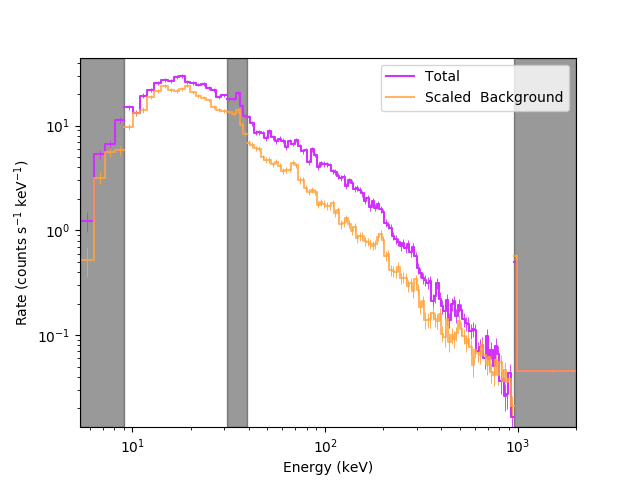

<IPython.core.display.Javascript object>


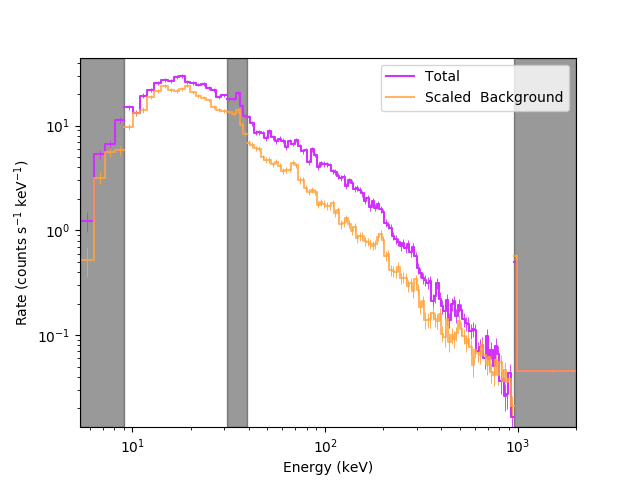

In [31]:
NaI6.view_count_spectrum()

Deselected regions are marked shaded in grey.

We have also view which channels fall below a given significance level:

<IPython.core.display.Javascript object>


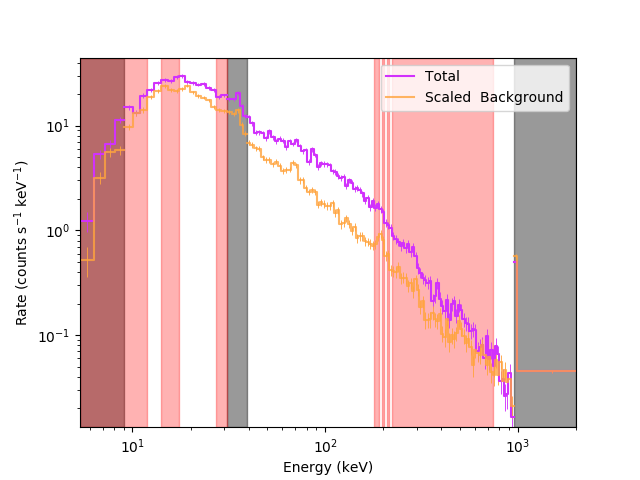

channels below the significance threshold shown in red



<IPython.core.display.Javascript object>


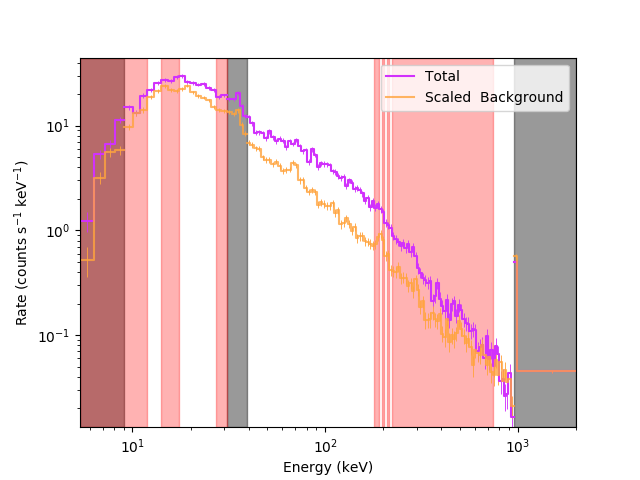

In [32]:
NaI6.view_count_spectrum(significance_level=5)

## Setup for spectral fitting

Now we will prepare the plugin for fitting by:
 * Creating a DataList
 * Selecting a spectral shape
 * Creating a likelihood model
 * Building a joint analysis object

In [3]:
#This declares which data we want to use. In our case, all that we have already created.

data_list = DataList( NaI6 )

In [4]:
powerlaw = Powerlaw()

In [5]:
GRB = PointSource( triggerName, ra, dec, spectral_shape=powerlaw )

In [6]:
model = Model( GRB )

In [7]:
jl = JointLikelihood( model, data_list, verbose=False )
#jl.set_minimizer('ROOT')
#%timeit res = jl.fit(quiet=True);

In [ ]:
import time
start = time.time()
res = jl.fit(quiet=True);
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
res = jl.fit(quiet=True);
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

In [8]:
import time
start = time.time()
res = jl.fit(quiet=True);
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
res = jl.fit(quiet=True);
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.582257032394
Elapsed (after compilation) = 0.0755579471588


In [9]:
%snakeviz jl.fit(quiet=True)

 
*** Profile stats marshalled to file u'/var/folders/w0/_d4080ln58g6hlxk73v516pc0000gn/T/tmpxd3__a'. 
Embedding SnakeViz in the notebook...


In [11]:
%snakeviz jl.fit(quiet=True)

 
*** Profile stats marshalled to file u'/var/folders/w0/_d4080ln58g6hlxk73v516pc0000gn/T/tmpbPZYbM'. 
Embedding SnakeViz in the notebook...


## Examining the fitted model

We can now look at the asymmetric errors, countours, etc. 

In [30]:
res = jl.get_errors()

Name,Value,Unit
bn090217206.spectrum.main.Powerlaw.K,2.53 -0.20 +0.21,1 / (cm2 keV s)
bn090217206.spectrum.main.Powerlaw.index,-1.183 +/- 0.015,


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<IPython.core.display.Javascript object>


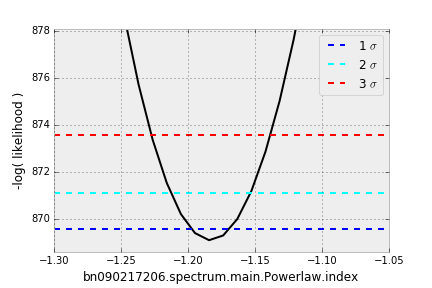

In [31]:
res = jl.get_contours(powerlaw.index,-1.3,-1.1,20)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<IPython.core.display.Javascript object>


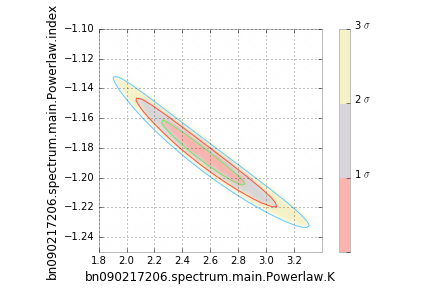

In [32]:
res = jl.get_contours(powerlaw.index,-1.25,-1.1,60,powerlaw.K,1.8,3.4,60)

And to plot the fit in the **data** space we call the data spectrum plotter:

<IPython.core.display.Javascript object>


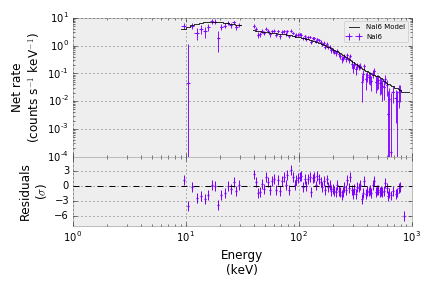

In [33]:
jl.restore_best_fit()

_=display_spectrum_model_counts(jl)

Or we can examine the fit in model space. Note that we must use the analysis_results of the joint likelihood for the model plotting:

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<IPython.core.display.Javascript object>


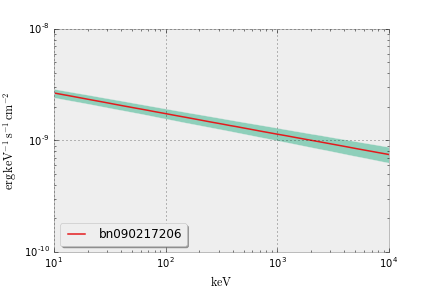

In [35]:
plot_point_source_spectra(jl.results,flux_unit='erg/(s cm2 keV)')

We can go Bayesian too!

In [36]:
powerlaw.index.prior = Uniform_prior(lower_bound=-5.0, upper_bound=5.0)
powerlaw.K.prior = Log_uniform_prior(lower_bound=1.0, upper_bound=10)

bayes = BayesianAnalysis(model, data_list)

In [37]:
samples = bayes.sample(n_walkers=50,burn_in=100, n_samples=1000)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Mean acceptance fraction: 0.71602

Maximum a posteriori probability (MAP) point:



,Value,Unit
bn090217206.spectrum.main.Powerlaw.K,2.52 -0.17 +0.22,1 / (cm2 keV s)
bn090217206.spectrum.main.Powerlaw.index,-1.183 -0.016 +0.013,



Values of -log(posterior) at the minimum:



,-log(posterior)
NaI6,-869.501547
total,-869.501547


<IPython.core.display.Javascript object>


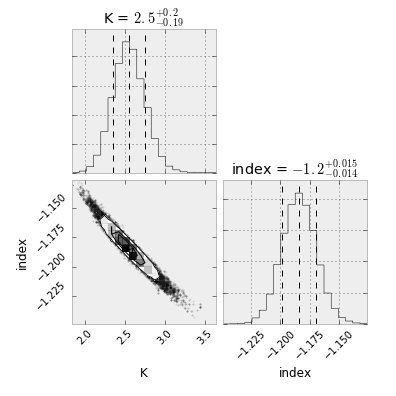

In [38]:
fig = bayes.corner_plot()

<IPython.core.display.Javascript object>


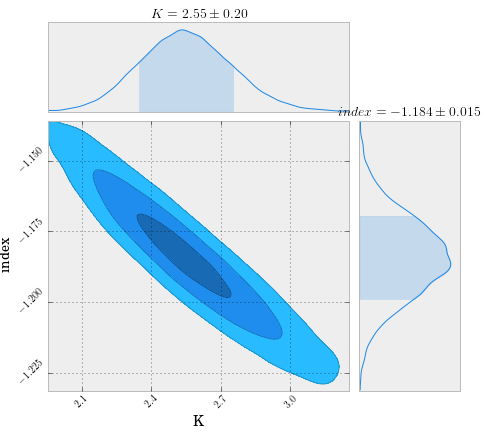

In [39]:
fig = bayes.corner_plot_cc()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<IPython.core.display.Javascript object>


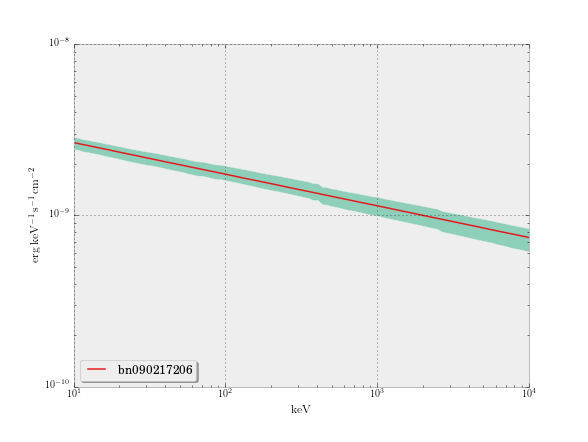

In [40]:
plot_point_source_spectra(bayes.results, flux_unit='erg/(cm2 s keV)',equal_tailed=False)